# Assignments Analysis: Job Description Clustering & Standardization

## Challenge #1: Job Description Clustering & Standardization

**Objective:**
- Cluster similar job descriptions into groups ("job families").
- Understand how close job descriptions are to each other.
- Identify what makes clusters different.

**Dataset:** `Hackathon_Datasets_Refined_v5.csv`

In [2]:
!pip install sentence-transformers pandas numpy scikit-learn seaborn matplotlib

  Using cached sentence_transformers-5.2.3-py3-none-any.whl.metadata (16 kB)
  Using cached transformers-5.2.0-py3-none-any.whl.metadata (32 kB)
  Using cached huggingface_hub-1.4.1-py3-none-any.whl.metadata (13 kB)
  Using cached tqdm-4.67.3-py3-none-any.whl.metadata (57 kB)
  Using cached tokenizers-0.22.2-cp39-abi3-macosx_11_0_arm64.whl.metadata (7.3 kB)
  Using cached typer_slim-0.24.0-py3-none-any.whl.metadata (4.2 kB)
  Using cached safetensors-0.7.0-cp38-abi3-macosx_11_0_arm64.whl.metadata (4.1 kB)
  Using cached hf_xet-1.2.0-cp37-abi3-macosx_11_0_arm64.whl.metadata (4.9 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached anyio-4.12.1-py3-none-any.whl.metadata (4.3 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
  Using cached h11-0.16.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached typer-0.24.0-py3-none-any.whl.metadata (16 kB)
  Using cached click-8.3.1

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

# Configuration
INPUT_FILE = 'Hackathon_Datasets_Refined_v5.csv'
MODEL_NAME = 'all-MiniLM-L6-v2'  # Efficient SBERT model
RANDOM_STATE = 42

/Users/rohanjasani/.pyenv/versions/3.12.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data Loading and Preparation
We will load the refined dataset and combine relevant text columns to create a rich representation of each job.

In [4]:
print(f"Loading data from {INPUT_FILE}...")
df = pd.read_csv(INPUT_FILE)

# Handle missing values
text_cols = ['Unified Job Title', 'position_summary', 'responsibilities', 'qualifications']
for col in text_cols:
    df[col] = df[col].fillna('')

# Create a combined text field for embedding
# We give more weight to the title by repeating it, or just putting it first.
df['full_text'] = (
    "Title: " + df['Unified Job Title'] + " . " +
    "Summary: " + df['position_summary'] + " . " +
    "Responsibilities: " + df['responsibilities'] + " . " +
    "Qualifications: " + df['qualifications']
)

print(f"Loaded {len(df)} job descriptions.")
df.head(2)

Loading data from Hackathon_Datasets_Refined_v5.csv...
Loaded 622 job descriptions.


,Unified Job Title,Job Level,Scope,Internal Posting,job_title,position_summary,responsibilities,qualifications,full_text
0,Finance Manager,Manager,NaN,No,finance manager posting,The Finance Manager is accountable for the pri...,Responsible for the Methanex Medicine Hat acco...,"Technical Skills, Knowledge and Experience: B...",Title: Finance Manager . Summary: The Finance ...
1,Senior Process Engineer,Senior,NaN,No,senior process engineer posting,The Senior Process Engineer supports the Metha...,Supporting the operations department's efforts...,"Technical Skills, Knowledge and Experience Und...",Title: Senior Process Engineer . Summary: The ...


## 2. Generate Embeddings (SBERT)
We use Sentence-BERT to convert the text into numerical vectors that capture semantic meaning.

In [5]:
print(f"Loading SBERT model: {MODEL_NAME}...")
model = SentenceTransformer(MODEL_NAME)

print("Generating embeddings (this may take a moment)...")
embeddings = model.encode(df['full_text'].tolist(), show_progress_bar=True)

print(f"Embeddings shape: {embeddings.shape}")

Loading SBERT model: all-MiniLM-L6-v2...


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1348.19it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Generating embeddings (this may take a moment)...


Batches: 100%|██████████| 20/20 [00:06<00:00,  2.95it/s]

Embeddings shape: (622, 384)


## 3. Clustering (K-Means)
We will determine an optimal number of clusters and then apply K-Means.

Finding optimal number of clusters...


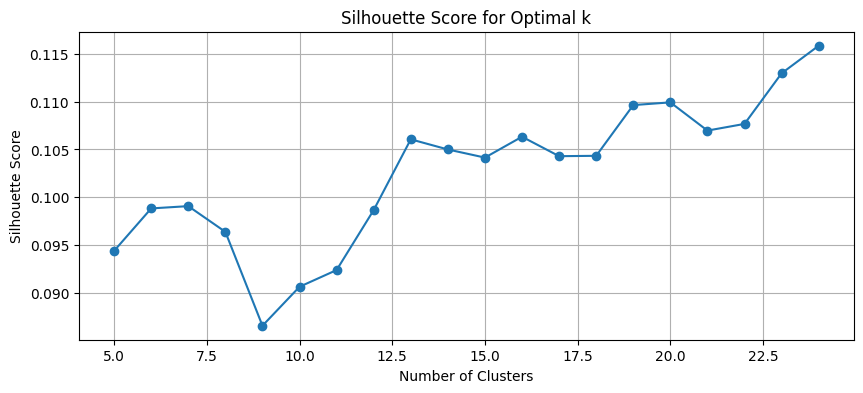

Best number of clusters based on Silhouette Score: 24
Using K=12 for final clustering.


In [6]:
# Determine optimal clusters using Silhouette Score
range_n_clusters = range(5, 25)
best_n_clusters = 5
best_score = -1
scores = []

print("Finding optimal number of clusters...")
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)
    silhouette_avg = silhouette_score(embeddings, cluster_labels)
    scores.append(silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters
    # print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg:.4f}")

# Plot Silhouette Scores
plt.figure(figsize=(10, 4))
plt.plot(range_n_clusters, scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

print(f"Best number of clusters based on Silhouette Score: {best_n_clusters}")

# Apply K-Means with best k (or a chosen practical number if best k is too low/high)
# For business interpretability, sometimes 10-15 is better even if score says otherwise.
# Let's stick to the metric unless it's extreme.
FINAL_K = best_n_clusters if 5 <= best_n_clusters <= 20 else 12
print(f"Using K={FINAL_K} for final clustering.")

kmeans = KMeans(n_clusters=FINAL_K, random_state=RANDOM_STATE, n_init=10)
df['Cluster'] = kmeans.fit_predict(embeddings)

## 4. Visualization (PCA)
Reduce dimensionality to 2D to visualize the clusters.

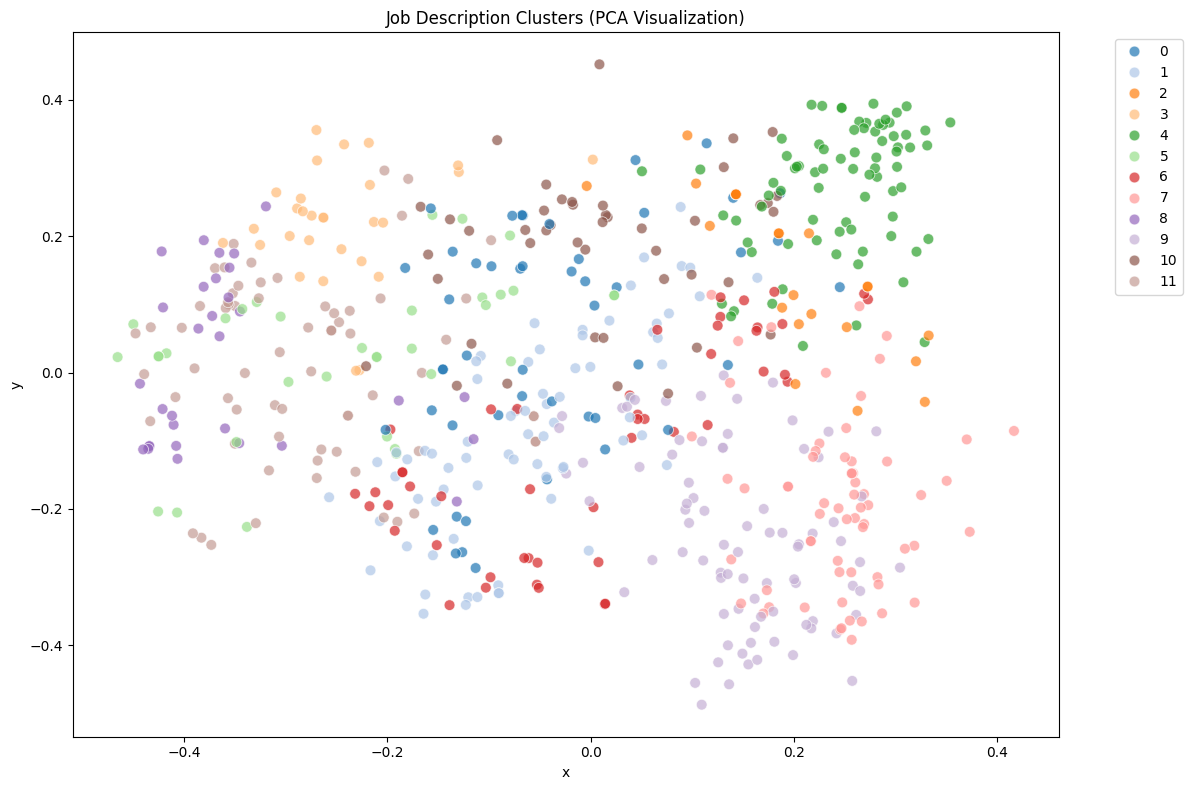

In [7]:
pca = PCA(n_components=2)
coords = pca.fit_transform(embeddings)

df['x'] = coords[:, 0]
df['y'] = coords[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='x', y='y', hue='Cluster', palette='tab20', s=60, alpha=0.7)
plt.title("Job Description Clusters (PCA Visualization)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 5. Cluster Interpretation & Labeling
For each cluster, we extract top keywords using TF-IDF and show representative titles.

In [8]:
def extract_cluster_keywords(tfidf, cluster_text, top_n=5):
    response = tfidf.transform([cluster_text])
    feature_names = tfidf.get_feature_names_out()
    sorted_nzs = np.argsort(response.data)[:-(top_n+1):-1]
    return [feature_names[response.indices[i]] for i in sorted_nzs]

# Calculate TF-IDF for the whole corpus for keyword extraction
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=5)
tfidf_vectorizer.fit(df['full_text'])

cluster_summaries = []

for i in range(FINAL_K):
    cluster_indices = df[df['Cluster'] == i].index
    cluster_df = df.loc[cluster_indices]
    
    # Get unified titles
    titles = cluster_df['Unified Job Title'].value_counts().head(3).index.tolist()
    title_str = ", ".join(titles)
    
    # Get keywords
    combined_text = " ".join(cluster_df['full_text'])
    keywords = extract_cluster_keywords(tfidf_vectorizer, combined_text, top_n=5)
    keyword_str = ", ".join(keywords)
    
    # Count
    count = len(cluster_df)
    
    cluster_summaries.append({
        'Cluster ID': i,
        'Count': count,
        'Representative Titles': title_str,
        'Top Keywords': keyword_str
    })

summary_df = pd.DataFrame(cluster_summaries)
pd.set_option('display.max_colwidth', None)
display(summary_df)

,Cluster ID,Count,Representative Titles,Top Keywords
0,0,48,"Executive Office Coordinator, Corporate Office Receptionist, Administrative Assistant Responsible Care","communications, office, administrative, ceo, travel"
1,1,72,"Manager, M&L Business Systems, Commercial Director -, Global Tactical Planner","supply, chain, logistics, market, regional"
2,2,23,"Senior Applications Analyst, Applications Analyst, Senior Systems Analyst","analyst, applications, senior, systems, lead"
3,3,29,"Auditor, Senior Auditor, Accounting Clerk","audit, internal, sox, accounting, compliance"
4,4,78,"Ie Engineer, Product Handler (Temp), Production Shift Supervisor","maintenance, plant, equipment, engineering, safety"
5,5,35,"Corporate Counsel, Manager, Treasury And Corporate Finance, Treasury Analyst","legal, corporate, treasury, cash, agreements"
6,6,48,"Director, Corporate Sustainability, Director Sustainability And Associate General Counsel, Finance Manager","sustainability, communications, esg, media, relations"
7,7,64,"Service Desk Analyst, Applications Analyst, Pd - Senior Functional Analyst","working, applications, solutions, service, user"
8,8,31,"Manager, Global Taxation, Manager, Transfer Pricing, Senior Tax Analyst","tax, pricing, transfer, taxation, accounting"
9,9,81,"Global IT Service Desk Lead, Senior Business Lead, M&L Systems, Regional IT Business Relationship Manager (Brm)","working, project, oracle, service, technology"


## 6. Standardization Insights & Outliers
Finding potential outliers (jobs far from cluster centroids) and opportunities for standardizing profiles.

In [9]:
# Find Distance to Centroids
centers = kmeans.cluster_centers_

def get_distance(row):
    cluster_center = centers[row['Cluster']]
    emb = model.encode(row['full_text'])
    return np.linalg.norm(emb - cluster_center)

# Note: Calculating distance for all rows again might be slow if dataset is huge, 
# but for 600 rows it's instant. To be efficient, we reuse embeddings.
distances = []
for idx, row in df.iterrows():
    emb = embeddings[idx]
    center = centers[int(row['Cluster'])]
    dist = np.linalg.norm(emb - center)
    distances.append(dist)

df['Distance_to_Center'] = distances

# Identify Outliers (Top 5% furthest points in each cluster)
outliers = []
for i in range(FINAL_K):
    cluster_df = df[df['Cluster'] == i]
    threshold = cluster_df['Distance_to_Center'].quantile(0.95)
    cluster_outliers = cluster_df[cluster_df['Distance_to_Center'] > threshold]
    outliers.append(cluster_outliers)

outliers_df = pd.concat(outliers)

print("Top Outliers (Jobs that perform unique or mixed functions):")
display(outliers_df[['Unified Job Title', 'Cluster', 'Distance_to_Center']].sort_values('Distance_to_Center', ascending=False).head(10))

Top Outliers (Jobs that perform unique or mixed functions):


,Unified Job Title,Cluster,Distance_to_Center
135,Ai Developer -,7,0.957195
117,Inventory Analyst - Medicine Hat,1,0.885348
30,Power Engineering Summer Student,4,0.878729
156,Power Engineering Summer Student -,4,0.874123
116,Drafter - Medicine Hat,4,0.863560
102,"Advisor, Global Mobility -",8,0.842696
370,"Bosch, Susan - Analyst, Tax And Transfer Pricing - Position Description",2,0.842498
32,Lab Technician Temp-,4,0.840909
143,"Manager, Finance -",11,0.828503
16,Tar Procurement Specialist,1,0.823191


## Conclusion

The analysis above provides the requested deliverables:
1.  **Job Description Clusters:** Identified `K` job families.
2.  **Visualization:** PCA plot shows the separation of these families.
3.  **Cluster Labels:** The summary table maps Cluster IDs to business functions (e.g., Engineering, Finance, HR).

**Standardization Opportunities:**
- Jobs within tight clusters (low average distance) are prime candidates for standardization.
- Outliers identified above may represent niche roles or roles with poor descriptions that need review.